## 📊 KcELECTRA vs 키워드 매칭 성능 비교

> 변형 욕설 탐지에서 딥러닝 모델(KcELECTRA)이 기존 키워드 매칭 방식보다 얼마나 효과적인지 비교합니다.

### 실행 전 필수 사항
1. **KcELECTRA 모델 학습 완료**: `KcElectra_학습.ipynb`를 먼저 실행하여 모델을 저장해야 합니다.
2. **모델 경로 확인**: `MODEL_PATH` 변수가 저장된 모델 경로와 일치하는지 확인하세요.

In [1]:
# ========================================
# 📦 패키지 설치 (필요시 실행)
# ========================================
%pip install torch transformers pandas matplotlib seaborn scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
# ========================================
# 🔧 경로 설정 (본인 환경에 맞게 수정)
# ========================================
import os

# 학습된 KcELECTRA 모델 경로 (KcElectra_학습.ipynb에서 저장한 경로)
MODEL_PATH = r"c:\00_Sookmyunguniv\DACOS(2025)\2학기\프로젝트\github\25-2-team3\kcelectra\kcelectra_output\best_model"

# 경로 확인
if not os.path.exists(MODEL_PATH):
    print(f"⚠️ 모델 경로를 찾을 수 없습니다: {MODEL_PATH}")
    print(f"   현재 작업 디렉토리: {os.getcwd()}")
    print(f"   먼저 KcElectra_학습.ipynb를 실행하여 모델을 저장하세요.")
else:
    print(f"📁 모델 경로: {MODEL_PATH}")

📁 모델 경로: ./kcelectra_output/best_model


In [3]:
# ========================================
# 📚 라이브러리 import
# ========================================
import os
import re
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("✅ 라이브러리 로드 완료!")

✅ 라이브러리 로드 완료!


---
## 1️⃣ 키워드 매칭 방식 정의

기존 방식: 욕설 키워드 목록에 포함되면 악성으로 판단

In [4]:
# ========================================
# 🔤 욕설 키워드 목록 (수정 가능)
# ========================================
# 이 목록을 수정하여 키워드 매칭 방식의 성능을 조절할 수 있습니다.

ABUSIVE_KEYWORDS = [
    # 일반 욕설
    "시발", "씨발", "개새끼", "병신", "지랄", "썅", "ㅅㅂ", "ㅂㅅ",
    "미친", "또라이", "찐따", "한남", "한녀", "느금마", "니애미", "애미",
    "좆", "보지", "자지", "섹스", "야동",
    "꺼져", "닥쳐", "죽어", "뒤져",
    
    # 초성 욕설
    "ㅅㅂ", "ㅂㅅ", "ㄱㅅㄲ", "ㅈㄹ", "ㄲㅈ", "ㄷㅊ",
    
    # 일부 변형 (기본적인 것만)
    "시bal", "씨bal",
]

print(f"📝 등록된 키워드 수: {len(ABUSIVE_KEYWORDS)}개")

📝 등록된 키워드 수: 33개


In [5]:
# ========================================
# 🔍 키워드 매칭 함수
# ========================================

def keyword_predict(texts):
    """
    키워드 매칭 방식으로 악성 댓글 탐지
    - 키워드가 포함되어 있으면 1 (악성)
    - 없으면 0 (정상)
    """
    results = []
    for text in texts:
        text_lower = text.lower()
        is_abusive = any(keyword in text_lower for keyword in ABUSIVE_KEYWORDS)
        results.append(1 if is_abusive else 0)
    return results

# 테스트
test_texts = ["시발 뭐야", "안녕하세요"]
print(f"키워드 매칭 테스트: {keyword_predict(test_texts)}")

키워드 매칭 테스트: [1, 0]


---
## 2️⃣ KcELECTRA 모델 로드

In [6]:
# ========================================
# 🤖 KcELECTRA 모델 로드
# ========================================

# 모델 경로 확인
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(
        f"모델을 찾을 수 없습니다: {MODEL_PATH}\n"
        f"먼저 'KcElectra_학습.ipynb'를 실행하여 모델을 학습하고 저장하세요."
    )

# 토크나이저 & 모델 로드
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

# GPU 사용 가능하면 GPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

print(f"✅ 모델 로드 완료! (Device: {device})")

✅ 모델 로드 완료! (Device: cuda)


In [7]:
# ========================================
# 🤖 KcELECTRA 예측 함수
# ========================================

def kcelectra_predict(texts, threshold=0.5):
    """
    KcELECTRA 모델로 악성 댓글 탐지
    Returns: (predictions, probabilities)
    """
    enc = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
    enc = {k: v.to(device) for k, v in enc.items()}
    
    with torch.no_grad():
        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
        preds = (probs >= threshold).astype(int)
    
    return preds.tolist(), probs.tolist()

# 테스트
preds, probs = kcelectra_predict(["시발 뭐야", "안녕하세요"])
print(f"KcELECTRA 테스트: preds={preds}, probs={[f'{p:.2%}' for p in probs]}")

KcELECTRA 테스트: preds=[1, 0], probs=['99.98%', '0.42%']


---
## 3️⃣ 테스트 데이터셋 정의

변형 욕설을 포함한 테스트 데이터셋을 정의합니다.

In [8]:
# ========================================
# 📋 테스트 데이터셋 (수정 가능)
# ========================================

test_data = [
    # === 일반 욕설 (키워드 매칭도 탐지 가능) ===
    {"text": "야 이 개새끼야", "label": 1, "category": "일반 욕설"},
    {"text": "시발 진짜 짜증나", "label": 1, "category": "일반 욕설"},
    {"text": "병신 같은 놈", "label": 1, "category": "일반 욕설"},
    {"text": "지랄하네 ㅋㅋ", "label": 1, "category": "일반 욕설"},
    {"text": "닥쳐 좀", "label": 1, "category": "일반 욕설"},
    
    # === 변형 욕설 (키워드 매칭이 탐지하기 어려움) ===
    {"text": "ㅅㅂ 뭐라는거야", "label": 1, "category": "변형 욕설"},
    {"text": "시1발 진짜", "label": 1, "category": "변형 욕설"},
    {"text": "씨@발 ㅋㅋ", "label": 1, "category": "변형 욕설"},
    {"text": "ㄱㅐㅅㄲ 같은 놈", "label": 1, "category": "변형 욕설"},
    {"text": "십팔ㅋㅋ 진짜", "label": 1, "category": "변형 욕설"},
    {"text": "ㅈㄹ 하지마", "label": 1, "category": "변형 욕설"},
    {"text": "시ㅃㅏㄹ", "label": 1, "category": "변형 욕설"},
    {"text": "ㅂ ㅅ 아냐?", "label": 1, "category": "변형 욕설"},
    {"text": "애미걸고 ㄹㅇ임", "label": 1, "category": "변형 욕설"},
    {"text": "ㅈ1랄마쇼", "label": 1, "category": "변형 욕설"},
    {"text": "쌈@뽕하구만", "label": 1, "category": "변형 욕설"},
    {"text": "비꼬지마셈 발작자제좀", "label": 1, "category": "변형 욕설"},
    {"text": "ㅇㅁ없는ㄴㅋㅋ 넌 나가라", "label": 1, "category": "변형 욕설"},
    {"text": "아잇 ㅈ됐네", "label": 1, "category": "변형 욕설"},
    {"text": "님 정신나감? 십팔ㅋㅋ", "label": 1, "category": "변형 욕설"},
    
    # === 정상 문장 ===
    {"text": "친절하게 도와주셔서 감사합니다", "label": 0, "category": "정상"},
    {"text": "아름다운 밤이네요", "label": 0, "category": "정상"},
    {"text": "오늘 날씨가 좋네요", "label": 0, "category": "정상"},
    {"text": "맛있는 저녁 드세요", "label": 0, "category": "정상"},
    {"text": "화이팅입니다!", "label": 0, "category": "정상"},
    {"text": "ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ", "label": 0, "category": "정상"},
    {"text": "나 노래방 십팔번 업슴", "label": 0, "category": "정상"},
    {"text": "개발자 되고 싶어요", "label": 0, "category": "정상"},
    {"text": "개새우튀김 맛있다", "label": 0, "category": "정상"},
    {"text": "물방개새우튀김", "label": 0, "category": "정상"},
]

# DataFrame으로 변환
test_df = pd.DataFrame(test_data)
print(f"📊 테스트 데이터 수: {len(test_df)}개")
print(f"\n카테고리별 분포:")
print(test_df['category'].value_counts())

📊 테스트 데이터 수: 30개

카테고리별 분포:
category
변형 욕설    15
정상       10
일반 욕설     5
Name: count, dtype: int64


---
## 4️⃣ 두 방식 비교 실행

In [9]:
# ========================================
# 🔄 두 방식으로 예측 수행
# ========================================

texts = test_df['text'].tolist()
labels = test_df['label'].tolist()

# 키워드 매칭 예측
keyword_preds = keyword_predict(texts)

# KcELECTRA 예측
kcelectra_preds, kcelectra_probs = kcelectra_predict(texts)

# 결과 저장
test_df['keyword_pred'] = keyword_preds
test_df['kcelectra_pred'] = kcelectra_preds
test_df['kcelectra_prob'] = kcelectra_probs

print("✅ 예측 완료!")

✅ 예측 완료!


In [10]:
# ========================================
# 📊 전체 성능 비교
# ========================================

def calculate_metrics(y_true, y_pred, name):
    """성능 지표 계산"""
    return {
        "방식": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1 Score": f1_score(y_true, y_pred, zero_division=0),
    }

# 전체 데이터 성능
keyword_metrics = calculate_metrics(labels, keyword_preds, "키워드 매칭")
kcelectra_metrics = calculate_metrics(labels, kcelectra_preds, "KcELECTRA")

metrics_df = pd.DataFrame([keyword_metrics, kcelectra_metrics])
print("\n📊 전체 성능 비교:")
print(metrics_df.to_string(index=False))


📊 전체 성능 비교:
       방식  Accuracy  Precision  Recall  F1 Score
   키워드 매칭       0.6   1.000000    0.40  0.571429
KcELECTRA       0.9   0.904762    0.95  0.926829


In [11]:
# ========================================
# 📊 카테고리별 성능 비교 (핵심!)
# ========================================

print("\n" + "="*60)
print("📊 카테고리별 성능 비교 (Recall 기준)")
print("="*60)

category_results = []

for category in test_df['category'].unique():
    subset = test_df[test_df['category'] == category]
    y_true = subset['label'].tolist()
    
    # 정상 카테고리는 label이 0이므로 다르게 계산
    if category == "정상":
        # 정상 문장을 정상으로 맞춘 비율 (True Negative Rate)
        keyword_correct = sum(1 for t, p in zip(y_true, subset['keyword_pred']) if t == p)
        kcelectra_correct = sum(1 for t, p in zip(y_true, subset['kcelectra_pred']) if t == p)
        keyword_rate = keyword_correct / len(y_true)
        kcelectra_rate = kcelectra_correct / len(y_true)
    else:
        # 악성 문장을 악성으로 맞춘 비율 (Recall)
        keyword_rate = recall_score(y_true, subset['keyword_pred'].tolist(), zero_division=0)
        kcelectra_rate = recall_score(y_true, subset['kcelectra_pred'].tolist(), zero_division=0)
    
    category_results.append({
        "카테고리": category,
        "데이터 수": len(subset),
        "키워드 매칭": f"{keyword_rate:.1%}",
        "KcELECTRA": f"{kcelectra_rate:.1%}",
        "차이": f"+{(kcelectra_rate - keyword_rate):.1%}" if kcelectra_rate >= keyword_rate else f"{(kcelectra_rate - keyword_rate):.1%}"
    })

category_df = pd.DataFrame(category_results)
print(category_df.to_string(index=False))


📊 카테고리별 성능 비교 (Recall 기준)
 카테고리  데이터 수 키워드 매칭 KcELECTRA     차이
일반 욕설      5 100.0%    100.0%  +0.0%
변형 욕설     15  20.0%     93.3% +73.3%
   정상     10 100.0%     80.0% -20.0%


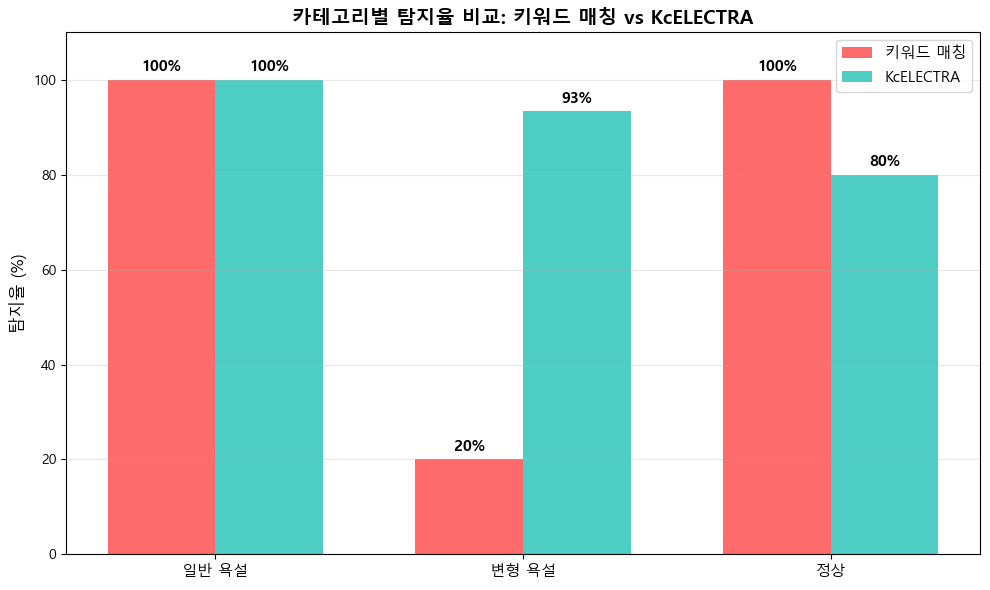


📁 차트 저장됨: comparison_chart.png


In [12]:
# ========================================
# 📈 시각화: 카테고리별 탐지율 비교
# ========================================

fig, ax = plt.subplots(figsize=(10, 6))

categories = ["일반 욕설", "변형 욕설", "정상"]
x = range(len(categories))
width = 0.35

# 카테고리별 정확도 계산
keyword_rates = []
kcelectra_rates = []

for category in categories:
    subset = test_df[test_df['category'] == category]
    y_true = subset['label'].tolist()
    
    if category == "정상":
        keyword_correct = sum(1 for t, p in zip(y_true, subset['keyword_pred']) if t == p)
        kcelectra_correct = sum(1 for t, p in zip(y_true, subset['kcelectra_pred']) if t == p)
        keyword_rates.append(keyword_correct / len(y_true) * 100)
        kcelectra_rates.append(kcelectra_correct / len(y_true) * 100)
    else:
        keyword_rates.append(recall_score(y_true, subset['keyword_pred'].tolist(), zero_division=0) * 100)
        kcelectra_rates.append(recall_score(y_true, subset['kcelectra_pred'].tolist(), zero_division=0) * 100)

bars1 = ax.bar([i - width/2 for i in x], keyword_rates, width, label='키워드 매칭', color='#FF6B6B')
bars2 = ax.bar([i + width/2 for i in x], kcelectra_rates, width, label='KcELECTRA', color='#4ECDC4')

# 막대 위에 수치 표시
for bar, rate in zip(bars1, keyword_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{rate:.0f}%', 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

for bar, rate in zip(bars2, kcelectra_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{rate:.0f}%', 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('탐지율 (%)', fontsize=12)
ax.set_title('카테고리별 탐지율 비교: 키워드 매칭 vs KcELECTRA', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=11)
ax.legend(fontsize=11)
ax.set_ylim(0, 110)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('comparison_chart.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📁 차트 저장됨: comparison_chart.png")

---
## 5️⃣ 상세 결과 확인

In [13]:
# ========================================
# 📝 개별 예측 결과 확인
# ========================================

print("\n" + "="*80)
print("📝 개별 예측 결과")
print("="*80)

for _, row in test_df.iterrows():
    text = row['text']
    label = "악성" if row['label'] == 1 else "정상"
    keyword = "악성" if row['keyword_pred'] == 1 else "정상"
    kcelectra = "악성" if row['kcelectra_pred'] == 1 else "정상"
    prob = row['kcelectra_prob']
    category = row['category']
    
    # 정답 여부 표시
    keyword_mark = "✅" if row['keyword_pred'] == row['label'] else "❌"
    kcelectra_mark = "✅" if row['kcelectra_pred'] == row['label'] else "❌"
    
    print(f"[{category}] {text}")
    print(f"  정답: {label} | 키워드: {keyword} {keyword_mark} | KcELECTRA: {kcelectra} ({prob:.1%}) {kcelectra_mark}")
    print()


📝 개별 예측 결과
[일반 욕설] 야 이 개새끼야
  정답: 악성 | 키워드: 악성 ✅ | KcELECTRA: 악성 (100.0%) ✅

[일반 욕설] 시발 진짜 짜증나
  정답: 악성 | 키워드: 악성 ✅ | KcELECTRA: 악성 (100.0%) ✅

[일반 욕설] 병신 같은 놈
  정답: 악성 | 키워드: 악성 ✅ | KcELECTRA: 악성 (100.0%) ✅

[일반 욕설] 지랄하네 ㅋㅋ
  정답: 악성 | 키워드: 악성 ✅ | KcELECTRA: 악성 (100.0%) ✅

[일반 욕설] 닥쳐 좀
  정답: 악성 | 키워드: 악성 ✅ | KcELECTRA: 악성 (99.8%) ✅

[변형 욕설] ㅅㅂ 뭐라는거야
  정답: 악성 | 키워드: 악성 ✅ | KcELECTRA: 악성 (100.0%) ✅

[변형 욕설] 시1발 진짜
  정답: 악성 | 키워드: 정상 ❌ | KcELECTRA: 악성 (99.6%) ✅

[변형 욕설] 씨@발 ㅋㅋ
  정답: 악성 | 키워드: 정상 ❌ | KcELECTRA: 악성 (100.0%) ✅

[변형 욕설] ㄱㅐㅅㄲ 같은 놈
  정답: 악성 | 키워드: 정상 ❌ | KcELECTRA: 악성 (100.0%) ✅

[변형 욕설] 십팔ㅋㅋ 진짜
  정답: 악성 | 키워드: 정상 ❌ | KcELECTRA: 악성 (99.9%) ✅

[변형 욕설] ㅈㄹ 하지마
  정답: 악성 | 키워드: 악성 ✅ | KcELECTRA: 악성 (99.9%) ✅

[변형 욕설] 시ㅃㅏㄹ
  정답: 악성 | 키워드: 정상 ❌ | KcELECTRA: 악성 (100.0%) ✅

[변형 욕설] ㅂ ㅅ 아냐?
  정답: 악성 | 키워드: 정상 ❌ | KcELECTRA: 악성 (99.9%) ✅

[변형 욕설] 애미걸고 ㄹㅇ임
  정답: 악성 | 키워드: 악성 ✅ | KcELECTRA: 악성 (72.9%) ✅

[변형 욕설] ㅈ1랄마쇼
  정답: 악성 | 키워드: 정상 ❌ | KcELECTRA: 악성 (99.3%) ✅

[변형 욕설] 쌈@뽕하구만
  정답: 악성 

In [14]:
# ========================================
# 🎯 키워드 매칭이 틀리고 KcELECTRA가 맞춘 케이스
# ========================================

print("\n" + "="*80)
print("🎯 키워드 매칭 실패 & KcELECTRA 성공 케이스")
print("="*80)

success_cases = test_df[
    (test_df['keyword_pred'] != test_df['label']) & 
    (test_df['kcelectra_pred'] == test_df['label'])
]

if len(success_cases) == 0:
    print("해당 케이스가 없습니다.")
else:
    for _, row in success_cases.iterrows():
        label = "악성" if row['label'] == 1 else "정상"
        print(f"• [{row['category']}] \"{row['text']}\"")
        print(f"  → 정답: {label}, KcELECTRA: {row['kcelectra_prob']:.1%} 확률로 정확히 탐지!")
        print()


🎯 키워드 매칭 실패 & KcELECTRA 성공 케이스
• [변형 욕설] "시1발 진짜"
  → 정답: 악성, KcELECTRA: 99.6% 확률로 정확히 탐지!

• [변형 욕설] "씨@발 ㅋㅋ"
  → 정답: 악성, KcELECTRA: 100.0% 확률로 정확히 탐지!

• [변형 욕설] "ㄱㅐㅅㄲ 같은 놈"
  → 정답: 악성, KcELECTRA: 100.0% 확률로 정확히 탐지!

• [변형 욕설] "십팔ㅋㅋ 진짜"
  → 정답: 악성, KcELECTRA: 99.9% 확률로 정확히 탐지!

• [변형 욕설] "시ㅃㅏㄹ"
  → 정답: 악성, KcELECTRA: 100.0% 확률로 정확히 탐지!

• [변형 욕설] "ㅂ ㅅ 아냐?"
  → 정답: 악성, KcELECTRA: 99.9% 확률로 정확히 탐지!

• [변형 욕설] "ㅈ1랄마쇼"
  → 정답: 악성, KcELECTRA: 99.3% 확률로 정확히 탐지!

• [변형 욕설] "쌈@뽕하구만"
  → 정답: 악성, KcELECTRA: 100.0% 확률로 정확히 탐지!

• [변형 욕설] "비꼬지마셈 발작자제좀"
  → 정답: 악성, KcELECTRA: 87.7% 확률로 정확히 탐지!

• [변형 욕설] "아잇 ㅈ됐네"
  → 정답: 악성, KcELECTRA: 99.9% 확률로 정확히 탐지!

• [변형 욕설] "님 정신나감? 십팔ㅋㅋ"
  → 정답: 악성, KcELECTRA: 99.9% 확률로 정확히 탐지!



---
## 📋 결론

### 키워드 매칭 방식의 한계
- 등록된 키워드만 탐지 가능
- **변형 욕설**(초성, 특수문자, 띄어쓰기 등)에 취약
- 키워드 목록 관리가 어려움 (무한히 늘어남)

### KcELECTRA의 장점
- **문맥 기반** 이해로 변형 욕설도 탐지
- 새로운 변형 패턴에도 대응 가능
- 확률값 제공으로 임계값 조정 가능